In [1]:
from init import config

config 読み込み -> config/config.ini
config 読み込み -> ../config/config.ini


# 移動平均線
時間の幅を変化させて比較。

- 気付き
    - bitflyerの曲線は、それまでの曲線は更新されていない。  
    最新の点を何らかの処理で求めて、それを繋げている。  
    おそらく、時間で区切った累計の値になる。
    - → 最新時間n分での平均をとる
    - → 調べてみたところ、**「移動平均線」**と呼ばれ、かなり一般的な手法らしい。。
      [参考リンク](http://hajihaji-lemon.com/bitcoin/exponential-moving-average/)
    
- 結果
    - 大体似てる。ロジックの本質は変わらないよう。
    - あとイジるとすれば、時間で重みづけするか、中央値や階級データでの最頻値を見るか。。
    
# TODO
- [参考リンク](http://hajihaji-lemon.com/bitcoin/exponential-moving-average/)を参考に、実装
- もっと軽量に動作するように

(2018/01/03追記)  
参考リンクを見ると、bitflyerは指数平均（EMA）を短期曲線、単純平均（SMA）を長期曲線としているよう。  
これもパラメータとして変更しなければ。。

In [3]:
# データ取得
import db
SAMPLING_SEC_BY = 60*100
ticker = db.df.read_ticker(sec_by=SAMPLING_SEC_BY)

2018-01-03 13:48:01,252 INFO sqlalchemy.engine.base.Engine DESCRIBE `SELECT * FROM ticker `
2018-01-03 13:48:01,256 INFO sqlalchemy.engine.base.Engine ()
2018-01-03 13:48:01,311 INFO sqlalchemy.engine.base.Engine SELECT * FROM ticker 
2018-01-03 13:48:01,312 INFO sqlalchemy.engine.base.Engine ()


# 最新版（2018/01/03）
- SMA（単純移動平均線 : Simple Moving Average）
    - 単純な移動平均。何分ごととか。
- ~~WMA（加重移動平均線 : Weighted Moving Average）~~
- EMA（指値平滑移動平均線 : Exponential Moving Average）
    - 逐次的に重み付けし、追加していく平均。最新の値に左右されやすい。

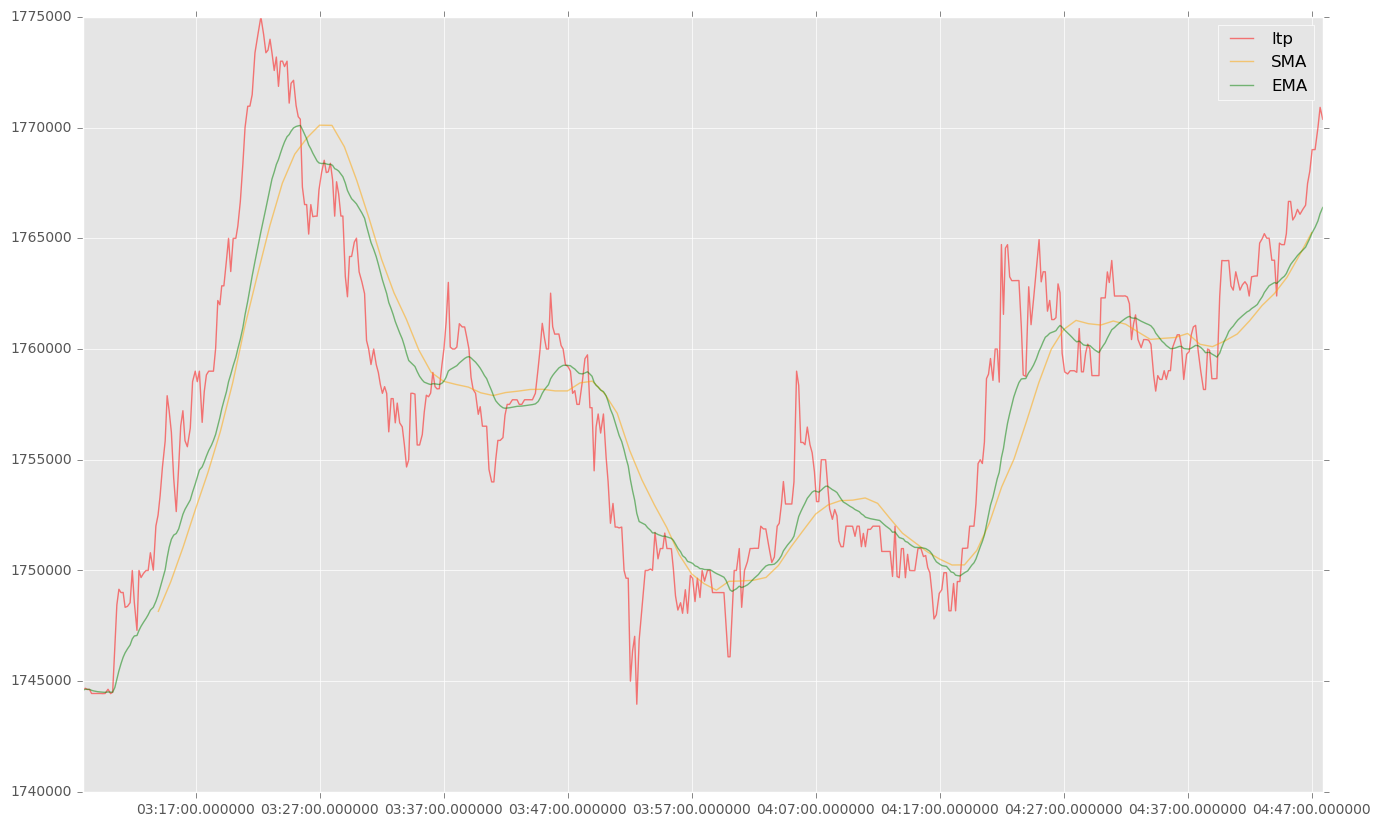

In [128]:
%matplotlib inline
import pandas as pd
from plotter.plot import plt, set_figure
set_figure((16,10))

#  元データ
ltp = ticker[["ltp"]]
plt.plot(ltp, label="ltp", alpha=0.5, color="r")

# 指定の単位でgroup by的にまとめておく。
ltp_min = ltp.groupby(pd.Grouper(freq='min')).mean()
# plt.plot(ltp_min, label="ltp_min", alpha=0.5, color="purple")

# SMA（単純移動平均 : Simple Moving Average）
sma = ltp_min.rolling(window=8).mean() # 分
plt.plot(sma, label="SMA", alpha=0.5, color="orange")

# EMA（指値平滑移動平均 : Exponentially Smoothed Moving Average）
# EWMA（指数加重移動平均  ： Exponentially Weighted Moving Average）
ema = ltp.ewm(span=30).mean()
plt.plot(ema, label="EMA", alpha=0.5, color="green")

_ = plt.legend()

# 以前の実装（2017/12/27）
単純平均のみの素の実装。  
pandasで既に実装されているとは知らなかったパターン  

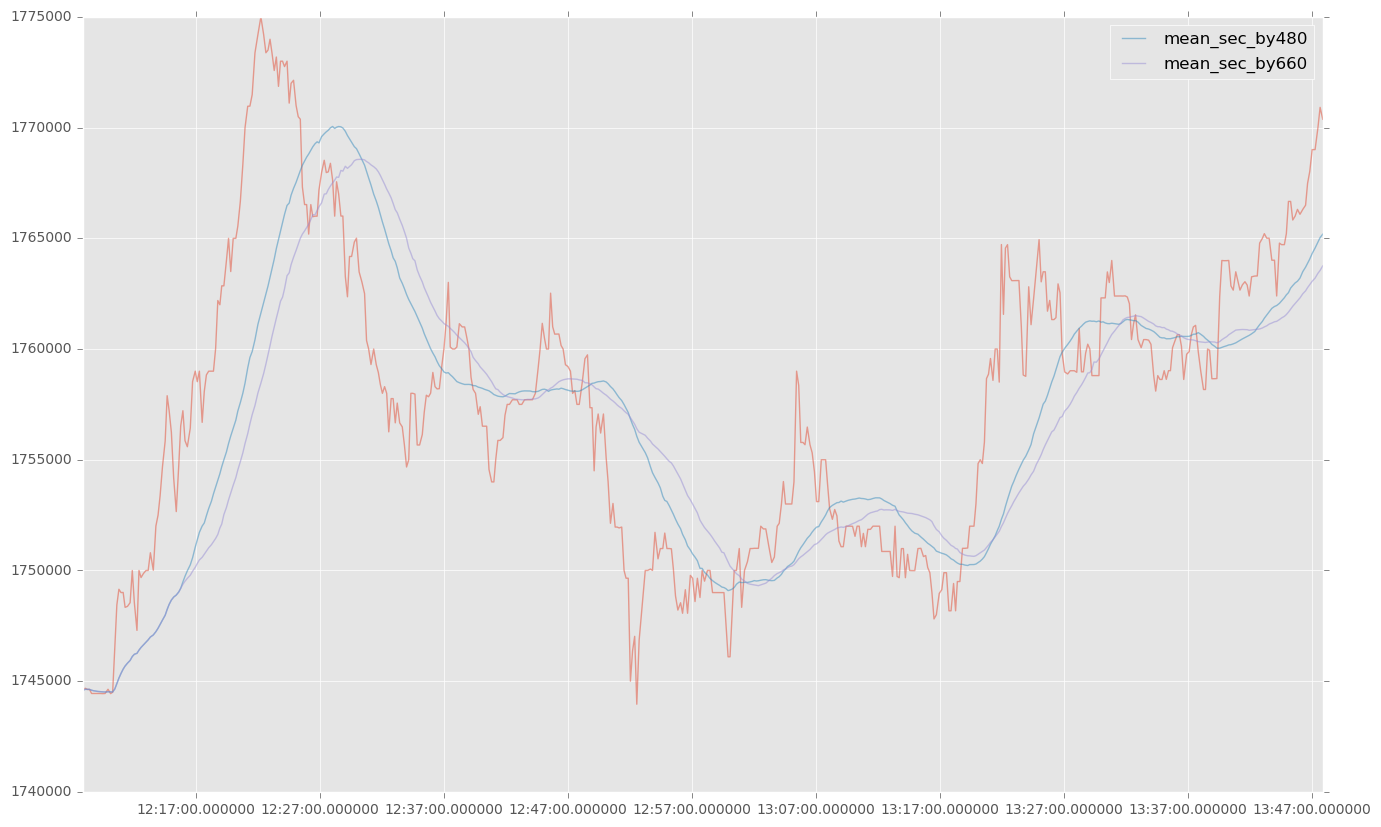

In [129]:
# 古いversion
%matplotlib inline
import numpy as np
import pandas as pd
import datetime
from plotter.plot import plt, set_figure
set_figure((16,10))

def gen_feature_ltp(ticker):
    ltp = ticker["ltp"]
    x_time = [time for time in ltp.index]
    x = np.array([i.timestamp() for i in x_time])
    y = ltp.tolist()
    return x_time, x, y

def raw_plot(ticker):
    x_time, x, y = gen_feature_ltp(ticker)
    plt.plot(x_time, y, "-", alpha=0.5)

def mean_plot(ticker, sec_by):
    x_time, x, y = gen_feature_ltp(ticker)
    means_y = []
    for i in range(1,len(x)+1):
        x_ = x_time[:i]
        y_ = y[:i]
        # 時間で抽出
        if sec_by is not None:
            df_ = pd.DataFrame(y_, x_)
            end_by = df_.index.max() - datetime.timedelta(seconds=sec_by)
            end_by = end_by.strftime('%Y-%m-%d %H:%M:%S')
            df_ = df_.loc[end_by:]
            y_mean = df_[0].mean()
        else:
            y_mean = y.mean()
        means_y.append(y_mean)
    plt.plot(x_time, means_y, "-", alpha=0.5, label="mean_sec_by{}".format(sec_by))

raw_plot(ticker)

# 目件で、暫定的に決定。
# 長期曲線は 11分平均
# 短期曲線は 8分平均
mean_plot(ticker, 60*8)
mean_plot(ticker, 60*11)
_ = plt.legend()